In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from sklearn.utils.class_weight import compute_class_weight
import numpy as np, os, math, matplotlib.pyplot as plt

In [ ]:
DATASET_DIR = "/content/drive/MyDrive/Datasets/Skin Cancer with Categories/Skin cancer ISIC/Train"
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 50
NUM_CLASSES = 9

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255.0, label

train_ds = train_ds.map(normalize_img)
val_ds = val_ds.map(normalize_img)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
classes = sorted([d for d in os.listdir(DATASET_DIR) if os.path.isdir(os.path.join(DATASET_DIR, d))])
count_per_class = [len(os.listdir(os.path.join(DATASET_DIR, c))) for c in classes]

class_weights_arr = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(classes)),
    y=np.concatenate([[i]*count for i,count in enumerate(count_per_class)])
)
class_weights = dict(enumerate(class_weights_arr * 0.5))
print("Pesos aplicados:", class_weights)

Pesos aplicados: {0: np.float64(1.091130604288499), 1: np.float64(0.33082151300236406), 2: np.float64(1.3093567251461988), 3: np.float64(0.28399289700659563), 4: np.float64(0.3484282601929661), 5: np.float64(0.2692400192400192), 6: np.float64(1.6154401154401155), 7: np.float64(0.6872314303253529), 8: np.float64(0.8948840927258194)}


In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.12),
    layers.RandomContrast(0.1)
])

In [ ]:
model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),

    data_augmentation,

    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.GlobalAveragePooling2D(),

    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),

    layers.Dense(NUM_CLASSES, activation='softmax')
])

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 129,481 (505.79 KB)

 Trainable params: 129,033 (504.04 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True,
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,
    min_lr=1e-6,
)


def lr_schedule(epoch):
    return 1e-5 + (5e-4 - 1e-5) * (1 + math.cos(epoch * math.pi / EPOCHS)) / 2

cosine_lr = LearningRateScheduler(lr_schedule)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr, cosine_lr],
    verbose=1
)


Epoch 1/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 155ms/step - accuracy: 0.2676 - loss: 0.9834 - val_accuracy: 0.1499 - val_loss: 2.3375 - learning_rate: 5.0000e-04
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 20s 175ms/step - accuracy: 0.3205 - loss: 0.8711 - val_accuracy: 0.1499 - val_loss: 2.3881 - learning_rate: 4.9952e-04
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 20s 179ms/step - accuracy: 0.3416 - loss: 0.8504 - val_accuracy: 0.2058 - val_loss: 2.2102 - learning_rate: 4.9807e-04
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 21s 189ms/step - accuracy: 0.3487 - loss: 0.7775 - val_accuracy: 0.2841 - val_loss: 1.9113 - learning_rate: 4.9566e-04
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 40s 183ms/step - accuracy: 0.3835 - loss: 0.7622 - val_accuracy: 0.2729 - val_loss: 1.9746 - learning_rate: 4.9230e-04
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 18s 162ms/step - accuracy: 0.3976 - loss: 0.7242 - val_accuracy: 0.1790 - val_loss: 2.6170 - learning_rate: 4.8801e-04
Epoch 7/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 20s 17

In [ ]:
save_path = "/content/drive/MyDrive/skin-cancer/saved_models/isic_multiclass_cnn_v2.3.keras"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
model.save(save_path)
print(f"✅ Modelo guardado correctamente en: {save_path}")

✅ Modelo guardado correctamente en: /content/drive/MyDrive/skin-cancer/saved_models/isic_multiclass_cnn_v2.3.keras


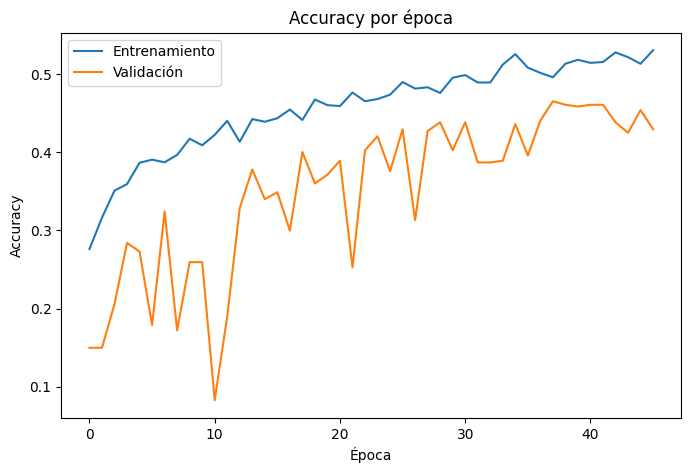

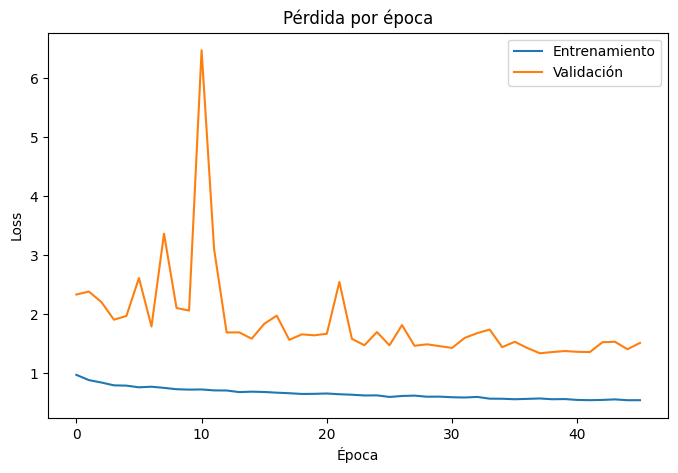

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title("Accuracy por época")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title("Pérdida por época")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.legend()
plt.show()